# Trabalho de Aprendizado de Máquina 
---
## Disciplina: Inteligência Artificial - PCI
### **Professora: Dra. Aline Paes**
### **Alunos:**
*   Régis Antônio Saraiva Albuquerque
*   Wilker Luiz Gadelha Maia

Preparar um relatório contendo:

1. uma pequena introdução, 
2. a descrição da base (e alguma análise exploratório que possa ter sido conduzida nela), 
3. a metodologia experimental, 
4. os resultados, 
5. e conclusões. 

In [ ]:
# Importar as Bibliotecas 

import pandas as pd
import spacy
# import nltk
import string
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt import Portuguese

# pip install -U scikit-learn scipy matplotlib
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

# Relatório de Experimentos com Algoritmos de Aprendizado de Máquina

# Introdução

Este relatório apresenta alguns experimentos com algoritmos de classificação do tipo Redes Neurais existentes na
plataforma scikitlearn no ambito de NLP. FOram realizados treinamentos e testes a fim de observar, entre
outras, as métricas de acurácia, por exemplo, que mede o quão frequente um
classificador está correto. A Matriz de Confusão consiste em uma tabela que
permite visualizar o desempenho de um algoritmo de classificação. Precisão
que de todas as classificações de classe Positivo que o modelo possui,
demonstra quantas estão corretas. Recall (Revocação) que, entre todas as
amostras, verifica quais realmente eram de uma classe, qual a proporção
classificada como da classe. E F1-Score que consiste na média harmônica
entre precisão e recall. Esta medida une precisão e recall em apenas uma
medida. Pode-se concluir que pelos testes realizados, os algoritmos apresentaram
alta eficiência para a base selecionada.

### Métricas de Teste
**Acurácia**: Mede o quão frequente um classificador está correto: 

Acurácia = quantidade de acertos / (quantidade de acertos - quantidade de
erros)

**Matriz de Confusão**: Consiste em uma tabela que permite visualizar o
desempenho de um algoritmo de classificação. As linhas da matriz
representam instâncias de uma classe prevista enquanto as colunas
representam instâncias da classe atual. Ela permite que seja feita uma análise
mais detalhada da situação do classificador uma vez que distingue os
resultados em quatro classes. Para um problema relacionado a identificação se
determinado e-mail é spam ou não:

Verdadeiros Positivos(True positive): casos em que a classe SPAM e o
e-mail realmente era um spam.

Falsos positivos(False positives): casos em que a classe SPAM e na
verdade eram e-mails comuns.

Falsos Verdadeiros (True Negative): casos onde era e-mail comum
(ausência de spam) e realmente eram.

Falsos Negativos (False Negative): casos em que eram spam e na verdade
eram spam.

**Precisão**: De todas as classificações de classe Positivo que o modelo faz,
quantas estão corretas? A fórmula é dada por:

Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivo)

**Recall (Revocação)**: Entre todas as amostras que realmente eram de uma
classe, qual a proporção classificada como da classe. A fórmula é dada por:

Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

**F1-Score**: Consiste na média harmônica entre precisão e recall. Esta medida
une precisão e recall em apenas uma medida.

F1 = 2 * precisão * recall / (precisão + recall).

# a descrição da base (e alguma análise exploratório que possa ter sido conduzida nela), 


A base de dados foi escolhida do conjunto de bases presente nesta url: https://forum.ailab.unb.br/t/datasets-em-portugues/251;

Base Escolhida: B2W-Reviews01
```
B2W-Reviews01 é um corpus aberto de reviews de produtos. Ele contém mais de 130 mil avaliações de clientes de comércio eletrônico, coletadas no site da Americanas.com entre janeiro e maio de 2018. O B2W-Reviews01 oferece informações valiosas sobre o perfil do avaliador, como sexo, idade e localização geográfica (Link: https://github.com/americanas-tech/b2w-reviews01). 
```




In [ ]:
# DATASET: https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv

df = pd.read_csv('https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv', dtype={'product_id': str, 'review_text': str})

# Imprimir parte do DataSet para entendimento
#print("Quantidade de Linhas: ", len(df.index))
#df.head(5)
# print (df.shape)

df.info()


## Nosso principal interesse é a coluna review_text e recommend_to_a_friend. Vamos remover todas as linhas que não possuem review e recommend_to_a_friend.

In [ ]:
print(df['review_text'].isnull().sum(),df['recommend_to_a_friend'].isnull().sum())

In [ ]:
# Remover linhas que tenham texto nulo
df.dropna(subset=['review_text'], inplace=True)
df.dropna(subset=['recommend_to_a_friend'], inplace=True)

In [ ]:
print(df['review_text'].isnull().sum(),df['recommend_to_a_friend'].isnull().sum())

### Agora vamos remover as colunas desnecessárias

In [ ]:
# focar no texto e ignorar as demais colunas
comp_df = df[['review_text','recommend_to_a_friend']]
comp_df.columns =['text','label']
comp_df.info()

In [ ]:
comp_df['label'].value_counts().plot.bar()
print(comp_df['label'].value_counts())

In [ ]:
# Transformar o rótulo para númerico

comp_df['label'] = comp_df.label.replace('Yes', 1)
comp_df['label'] = comp_df.label.replace('No',2)

In [ ]:
comp_df.head()

### A baixo é feito a limpeza da base, removendo caracteres especiais com expressões regulares. Experimentar diferentes estratégias de normalização (pré-processamento) (p.ex., remoção de stop-words, lematização, etc).  impeza e normalização 

In [ ]:
#Remove @ tags
comp_df.text = comp_df.text.str.replace(r'(@\w*)',"USER")

#Remove URL
comp_df.text = comp_df.text.str.replace(r"http\S+", "HTTP")

#Remove # tag
comp_df.text = comp_df.text.str.replace(r'#+',"")


#Remove all non-character
#comp_df.text = comp_df.text.str.replace(r"[^a-zA-Z ]","")

# Remove extra space
comp_df.text = comp_df.text.str.replace(r'( +)'," ")
comp_df.text = comp_df.text.str.strip()

# Remove números
comp_df.text = comp_df.text.str.replace('\d+', '')

# Change to lowercase
comp_df.text = comp_df.text.str.lower()

In [ ]:
comp_df.head(20)

In [ ]:
!python -m spacy download pt

!python -m spacy download pt_core_news_lg

In [ ]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("pt_core_news_sm") 
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

#parser = English()


# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    #mytokens = nlp(sentence)
    #print(mytokens)
    #for word in mytokens:
    #  print(word.lemma_)

    # Lemmatizing each token and converting each token into lowercase
    #mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    #print(mytokens)
    #mytokens = [ word.lemma_.lower().strip() for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    #print(mytokens)

    # return preprocessed list of tokens
    return mytokens

In [47]:
teste = comp_df.head(5000)
teste['corpus'] = [spacy_tokenizer(text) for text in teste.text]
teste.head()

/tmp/ipykernel_11065/878057982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste['corpus'] = [spacy_tokenizer(text) for text in teste.text]


,text,label,corpus
0,estou contente com a compra entrega rápida o ú...,1,"[contente, compra, entregar, rápido, único, pr..."
1,"por apenas r$.,eu consegui comprar esse lindo ...",1,"[r$, .,eu, conseguir, comprar, lindo, copo, ac..."
2,supera em agilidade e praticidade outras panel...,1,"[superar, agilidade, praticidade, outro, panel..."
3,meu filho amou! parece de verdade com tantos d...,1,"[filho, amar, parecer, verdade, detalhe]"
4,"a entrega foi no prazo, as americanas estão de...",1,"[entrega, em o, prazo, americana, parabéns, sm..."


In [48]:
teste.corpus = teste.apply(lambda x: " ".join(x.corpus),axis=1)
teste.head()

/tmp/ipykernel_11065/3693335669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teste.corpus = teste.apply(lambda x: " ".join(x.corpus),axis=1)


,text,label,corpus
0,estou contente com a compra entrega rápida o ú...,1,contente compra entregar rápido único problema...
1,"por apenas r$.,eu consegui comprar esse lindo ...",1,"r$ .,eu conseguir comprar lindo copo acrílico"
2,supera em agilidade e praticidade outras panel...,1,superar agilidade praticidade outro panela elé...
3,meu filho amou! parece de verdade com tantos d...,1,filho amar parecer verdade detalhe
4,"a entrega foi no prazo, as americanas estão de...",1,entrega em o prazo americana parabéns smart tv...



#  A metodologia experimental, 

Após a preparação dos dados vamos realizar os experimentos com os classificadores de rede neural do scikit learn

A avaliação dos algoritmos foi feita em um computador com processador Intel
Corei7-9750H de 2.60GHz, 15,5 GiB de memória RAM, 64 bits, placa de vídeo
GeForce GTX 1660 Ti Mobile e Internet com velocidade de 300Mbps. O
sistema operacional utilizado para os testes foi a distribuição GNU/Linux
Ubuntu 22.04.4. LTS.

# Vamos dividir a base em treino e teste

In [49]:
train_df = teste.head(4000)
test_df = teste.tail(1000)

In [51]:
x_train = train_df.corpus
y_train = train_df.label

x_test = test_df.corpus
y_test = test_df.label

freq_vector = CountVectorizer(min_df=5, ngram_range=(1,2),stop_words='english').fit(teste.corpus)

x_train = freq_vector.transform(x_train)
x_test = freq_vector.transform(x_test)

print(x_train.shape)
print(x_test.shape)

(4000, 2198)
(1000, 2198)


## Utilizamos o classificador MLPClassifier (Multi-layer Perceptron classifier.)


https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [55]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(x_train, y_train)

from sklearn.metrics import precision_recall_fscore_support
#y_pred_train=clf.predict(x_train)
#precision_recall_fscore_support(y_train, y_pred_train, average='macro')

y_pred=clf.predict(x_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.7899627775638557, 0.7988369816552111, 0.7941840047103206, None)

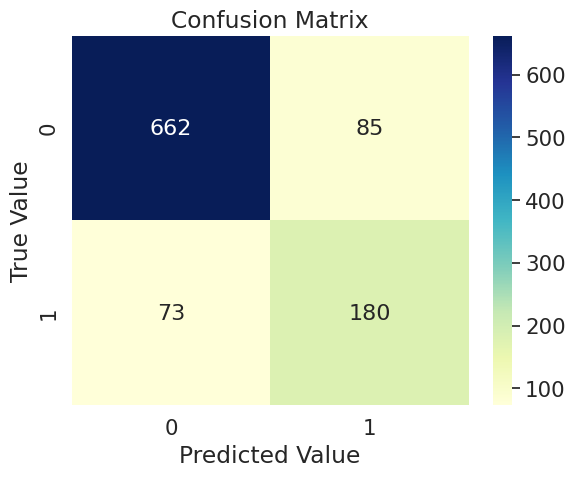

In [56]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
def plot_cm(conf_matrix):
  sns.set(font_scale=1.4,color_codes=True,palette="deep")
  sns.heatmap(cm,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")
plot_cm(cm)

# Experimentar com ao menos duas alterações de hiperparâmetros (tipo da ativação, alteração na arquitetura, otimizador, ajuste da taxa de aprendizado, ajustar ou não a taxa de aprendizado, etc).

In [57]:
cross_val_score(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), x_train, y_train, cv=10, verbose=1, n_jobs=-1).mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/home/regis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


0.849

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/regis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/regis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/regis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

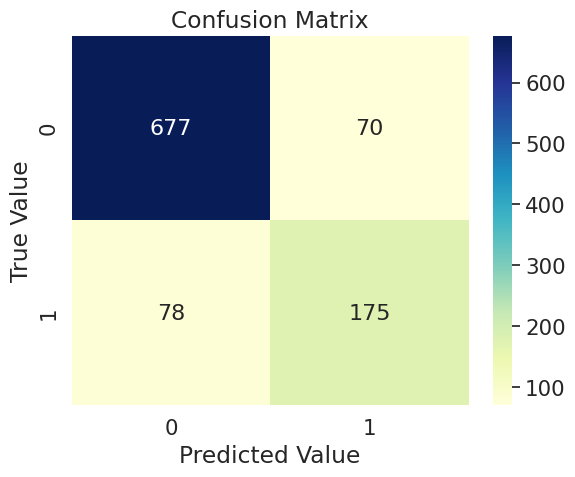

In [62]:
params = {
    #'solver':['lbfgs', 'sgd', 'adam'],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate_init': [0.001,0.01,0.1]
}

lr_grid = GridSearchCV(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1),params, cv=5, verbose=2, n_jobs=-1)
lr_grid.fit(x_train, y_train)

y_predict=lr_grid.predict(x_test)
cm=confusion_matrix(y_test, y_predict)
plot_cm(cm)

In [63]:
precision_recall_fscore_support(y_test, y_predict, average='macro')

(0.8054872280037844, 0.7989957193728802, 0.8021379793474831, None)

[CV] END ......activation=identity, learning_rate_init=0.001; total time=   0.4s
[CV] END ......activation=logistic, learning_rate_init=0.001; total time=   1.3s
[CV] END ........activation=logistic, learning_rate_init=0.1; total time=   1.3s
[CV] END ..........activation=relu, learning_rate_init=0.001; total time=   0.8s
[CV] END .......activation=identity, learning_rate_init=0.01; total time=   0.4s
[CV] END .......activation=logistic, learning_rate_init=0.01; total time=   1.3s
[CV] END ...........activation=tanh, learning_rate_init=0.01; total time=   0.4s
[CV] END ............activation=tanh, learning_rate_init=0.1; total time=   0.4s
[CV] END ..........activation=relu, learning_rate_init=0.001; total time=   1.2s
[CV] END ......activation=identity, learning_rate_init=0.001; total time=   0.4s
[CV] END ......activation=logistic, learning_rate_init=0.001; total time=   1.3s
[CV] END ........activation=logistic, learning_rate_init=0.1; total time=   1.4s
[CV] END ...........activati

# os resultados, 
# e conclusões. 

Os databases em formato csv e os códigos python podem ser acessados no
repositório: https://github.com/regisalbuquerque/ia_trab01

## Conclusão

